## Preface

This is an analysis of Wikipedia comments to create models that identify various types of toxic comments. There is a lot of racist content and swear words in the dataset and some of it will pop up in the analysis. 

In [7]:
import pandas as pd
import pickle
import numpy as np
import nltk
from nltk.corpus import stopwords
import keras
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import namedtuple
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.pipeline import make_union
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import confusion_matrix

In [8]:
# Global random state and k-fold strategy 
seed = 42
k = 5
cv = StratifiedKFold(n_splits=k, random_state=seed)

In [9]:
def lgb_f1_score(y_hat, data):
    # https://stackoverflow.com/questions/49774825/python-lightgbm-cross-validation-how-to-use-lightgbm-cv-for-regression
    y_true = data.get_label()
    y_hat = np.round(y_hat) 
    return 'f1', f1_score(y_true, y_hat), True

In [10]:
start = time.time()
def print_time(start):
    time_now = time.time() - start 
    minutes = int(time_now / 60)
    seconds = int(time_now % 60)
    if seconds < 10:
        print('Elapsed time was %d:0%d.' % (minutes, seconds))
    else:
        print('Elapsed time was %d:%d.' % (minutes, seconds))

## Feature Engineering 

In [11]:
def feature_engineering(df, sparse=0): 
    
    # Comment length
    df['length'] = df.comment_text.apply(lambda x: len(x))
    

    # Capitalization percentage
    def pct_caps(s):
        return sum([1 for c in s if c.isupper()]) / (sum(([1 for c in s if c.isalpha()])) + 1)
    df['caps'] = df.comment_text.apply(lambda x: pct_caps(x))

    # Mean Word length 
    def word_length(s):
        s = s.split(' ')
        return np.mean([len(w) for w in s if w.isalpha()])
    df['word_length'] = df.comment_text.apply(lambda x: word_length(x))

    # Average number of exclamation points 
    df['exclamation'] = df.comment_text.apply(lambda s: len([c for c in s if c == '!']))

    # Average number of question marks 
    df['question'] = df.comment_text.apply(lambda s: len([c for c in s if c == '?']))
    
    # Normalize
    for label in ['length', 'caps', 'word_length', 'question', 'exclamation']:
        minimum = df[label].min()
        diff = df[label].max() - minimum
        df[label] = df[label].apply(lambda x: (x-minimum) / (diff))

    # Strip IP Addresses
    ip = re.compile('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}'
                    +'(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))')
    def strip_ip(s, ip):
        try:
            found = ip.search(s)
            return s.replace(found.group(), ' ')
        except:
            return s

    df.comment_text = df.comment_text.apply(lambda x: strip_ip(x, ip))
    
    return df

def merge_features(comment_text, data, engineered_features):
    new_features = sparse.csr_matrix(df[engineered_features].values)
    if np.isnan(new_features.data).any():
        new_features.data = np.nan_to_num(new_features.data)
    return sparse.hstack([comment_text, new_features])

## Loading Dataset

In [12]:
# Reset data and create holdout set. 

df = pd.read_csv('train.csv')
targets = list(df.columns[2:])
df_targets = df[targets].copy()

df_sub = pd.read_csv('test.csv', dtype={'id': object}, na_filter=False)

submission = pd.DataFrame()
submission['id'] = df_sub.id.copy()

# Feature Engineering
df = feature_engineering(df)
df_sub = feature_engineering(df_sub)

print('Training labels:')
print(list(df_targets.columns))
print(df_targets.shape)

print('\nTraining data')
df.drop(list(df_targets.columns), inplace=True, axis=1)
df.drop('id', inplace=True, axis=1)
print(list(df.columns))
print(df.shape)


print('\nSubmission data')
df_sub.drop('id', inplace=True, axis=1)
print(list(df_sub.columns))
print(df_sub.shape)

toxic_rows = df_targets.sum(axis=1)
toxic_rows = (toxic_rows > 0)
targets.append('any_label')
df_targets['any_label'] = toxic_rows.astype(int)

new_features = list(df.columns[1:])
print(new_features)

from sklearn.model_selection import train_test_split
df, holdout, df_targets, holdout_targets = train_test_split(df, df_targets, test_size=0.2, random_state=seed)

/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Training labels:
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
(159571, 6)

Training data
['comment_text', 'length', 'caps', 'word_length', 'exclamation', 'question']
(159571, 6)

Submission data
['comment_text', 'length', 'caps', 'word_length', 'exclamation', 'question']
(153164, 6)
['length', 'caps', 'word_length', 'exclamation', 'question']


In [13]:
new_features

['length', 'caps', 'word_length', 'exclamation', 'question']

## Multilabel Function 

In [14]:
from sklearn.base import clone
#todo 
# Weights for 
def multi_cv(model, data, labels, k=5, nb_features=False):
    cv = StratifiedKFold(n_splits=k, random_state=seed)
    # Creating NB features just once from any_label has about the same 
    # performance as individual labels with faster speed. 
    def log_count_ratio(x, y):
        x = sparse.csr_matrix(x)
        # WARNING: Some scipy modules use indexes that start at 1! 
        # You need to add 1 to an index when performing operations on a csr_matrix 

        p = abs(x[np.where(y==1)].sum(axis=0))
        p = p + 1
        p = p / np.sum(p)

        q = abs(x[np.where(y==0)].sum(axis=0))
        q = q + 1
        q = q / np.sum(q)

        return np.log(p/q)
    
    # Labels must be in a dataframe
    scores = []
    r_values = []
    for label in labels.columns:
        if nb_features:
            r = log_count_ratio(data, labels[label])
            r_values.append(r)
            data = data.multiply(r)
            if np.isnan(data.data).any():
                data.data = np.nan_to_num(data.data)
        score = np.mean(cross_val_score(clone(model), data, labels[label], scoring='f1', cv=cv))
        print(label + ' f1 score: %.4f' % score)
        scores.append(score)
    print('Average (excluding any) f1 score: %.4f' % np.mean(scores[:-1]))
    if nb_features:
        return scores, r_values
    else:
        return scores

#training_comments.data = np.nan_to_num(training_comments.data)

#model = LinearSVC()
#_ = multi_cv(model, training_comments, df_targets, nb_features=True)

## NB Feature Transformer 

This is the primary method that I will use for the NB-SVM models, but I've left other code in to use as a reference. 

In [16]:
class NBFeatures:
    def __init__(self, epsilon=1, sparse=True):
        # How much influence NB features have 
        if not epsilon > 0 and epsilon <= 1:
            raise Exception("Invalid Epsilon value. Must be greater than zero and less than or equal to one.")
        self.epsilon = epsilon
        self.r = None
    
    def log_count_ratio(self, x, y):
        x = sparse.csr_matrix(x)
        # WARNING: Some scipy authors fall in the "index starts at 1" camp
        # You need to add 1 to an index when performing operations on a csr_matrix 
        p = abs(x[np.where(y==1)].sum(axis=0))
        p = p + 1
        p = p / np.sum(p)
        q = abs(x[np.where(y==0)].sum(axis=0))
        q = q + 1
        q = q / np.sum(q)
        return np.log(p/q)
    
    def fit(self, x, y):
        self.r = self.log_count_ratio(x, y)
    
    def transform(self, x):
        if self.r == None: 
            raise Exception("Model not fit, can't transform.")
        transformed = x.multiply(self.r)
        return x.multiply(1-self.epsilon) + transformed.multiply(self.epsilon)
        #return np.multiply(x, self.r)
    
    def fit_transform(self, x, y):
        self.r = self.log_count_ratio(x, y)
        return self.transform(x, y)


#nb_trans = NBFeatures(0.5)
#new = nb_trans.fit_transform(training_comments, np.array(df_targets.iloc[:,-1]))
#nb_trans.r.shape

A separate helper function to calculate the log count ratio that can be used for experimentation. 

In [9]:
def log_count_ratio(x, y):
    x = sparse.csr_matrix(x)
    # WARNING: Some scipy authors fall in the "index starts at 1" camp
    # You need to add 1 to an index when performing operations on a csr_matrix 

    p = abs(x[np.where(y==1)].sum(axis=0))
    p = p + 1
    p = p / np.sum(p)

    q = abs(x[np.where(y==0)].sum(axis=0))
    q = q + 1
    q = q / np.sum(q)

    return np.log(p/q)


# Vectorizing text

It's necessary to vectorize text before inputting into machine learning models. This is a process of translating string data into numerical data that the computer can better understand. Vectorized data is usually sparse, with an array where the features contain either word counts or another way of representing the occurance of characters or words in a string. This is done with a vectorizer object, which stores a dictionary of characters or words and their associated integer representation, along with relevant statistics if applicable. 

The strategy I'm going to use here is term frequency - inverse document frequency. This is a statistic that describes the usefulness of a string of characters by looking at the frequency that it occurs in an individual document (here, a single comment) and the inverse of its frequency in all of the documents in the dataset. 

That means that a word that is used frequently in a comment in this dataset, but that few comments in the dataset feature, is probably useful to the model. But a string that occurs in nearly every document is almost useless. 

In [15]:
start = time.time()
comment_vector = TfidfVectorizer(max_features=10000, analyzer='word', #ngram_range=(2, 6), 
                                 stop_words='english')
training_comments = comment_vector.fit_transform(df.comment_text)
holdout_comments = comment_vector.transform(holdout.comment_text)
submission_comments = comment_vector.transform(df_sub.comment_text)
print_time(start)

print(training_comments.shape)

Elapsed time was 0:19.
(127656, 10000)


One of the most important parameters to tune in this problem is the number of features and the n_gram range in the TF-IDF vectorizer, as well as choosing whether to analyze the sequences by characters or words. Analyzing by single words initially gives very poor performance, possibly because slang words and misspellings reduce the frequency of individual bad words.  

This is a simple function to play with reducing class imbalance. 

In [16]:
# This is just experimental to learn about the behavior of models with imbalanced classes. 

from numpy.random import sample

def imbalance_reduction(p, y):
    """
    For multilabel problems, keeps all rows with a 
    positive label and returns p% of data where label is zero. 
    """
    #reduce y
    y = np.sum(y, axis=1)
    p = 1-p
    keep_index = sample(len(y))
    keep_index = keep_index + y
    keep_index[keep_index>=p] = 1
    keep_index[keep_index<p] = 0

    return np.where(keep_index==1)

# Benchmarks

### Logistic Regression

With 10,000 vectorized features, but without engineered features. 

In [26]:

start = time.time()
for target in targets: 
    lr = LogisticRegression(random_state=seed)
    print(target + ' score: %.4f' % np.mean(cross_val_score(lr, training_comments, df_targets[target], scoring='f1', cv=cv)))
print_time(start)

toxic score: 0.7192
severe_toxic score: 0.3224
obscene score: 0.7452
threat score: 0.2069
insult score: 0.6277
identity_hate score: 0.2772
any_label score: 0.7299
Elapsed time was 0:43.


With engineered features added in. 

In [28]:
start = time.time()
for target in targets: 
    lr = LogisticRegression(random_state=seed)
    print(target + ' score: %.4f' % np.mean(cross_val_score(lr, merge_features(training_comments, df, new_features), df_targets[target], scoring='f1', cv=cv)))
print_time(start)

toxic score: 0.7235
severe_toxic score: 0.3475
obscene score: 0.7440
threat score: 0.2029
insult score: 0.6274
identity_hate score: 0.2768
any_label score: 0.7328
Elapsed time was 0:54.


### Naive Bayes

In [34]:
start = time.time() 

model = MultinomialNB(alpha=1.0)
_ = multi_cv(model, training_comments, df_targets)
print_time(start)

toxic f1 score: 0.6581
severe_toxic f1 score: 0.1032
obscene f1 score: 0.6672


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threat f1 score: 0.0000
insult f1 score: 0.5603
identity_hate f1 score: 0.0418
any_label f1 score: 0.6670
Average (excluding any) f1 score: 0.3384
Elapsed time was 0:02.


With engineered features. 

In [35]:
start = time.time() 

model = MultinomialNB(alpha=1.0)
_ = multi_cv(model, merge_features(training_comments, df, new_features), df_targets)
print_time(start)

toxic f1 score: 0.6662
severe_toxic f1 score: 0.0992
obscene f1 score: 0.6742


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threat f1 score: 0.0000
insult f1 score: 0.5708
identity_hate f1 score: 0.0369
any_label f1 score: 0.6734
Average (excluding any) f1 score: 0.3412
Elapsed time was 0:03.


### Support Vector Machine 

In [37]:
start = time.time()
model = LinearSVC(random_state=seed)
_ = multi_cv(model, training_comments, df_targets)
print_time(start)

toxic f1 score: 0.7551
severe_toxic f1 score: 0.3382
obscene f1 score: 0.7806
threat f1 score: 0.3658
insult f1 score: 0.6643
identity_hate f1 score: 0.3562
any_label f1 score: 0.7703
Average (excluding any) f1 score: 0.5434
Elapsed time was 0:25.


In [38]:
start = time.time()

model = LinearSVC(random_state=seed)
_ = multi_cv(model, merge_features(training_comments, df, new_features), df_targets)
print_time(start)

toxic f1 score: 0.7594
severe_toxic f1 score: 0.3492
obscene f1 score: 0.7797
threat f1 score: 0.3624
insult f1 score: 0.6643
identity_hate f1 score: 0.3548
any_label f1 score: 0.7739
Average (excluding any) f1 score: 0.5450
Elapsed time was 0:37.


### Support Vector Machine with Naive Bayes Features

In [41]:
nb = NBFeatures()
nb.fit(training_comments, df_targets.any_label)
nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df, new_features), df_targets.any_label)


Mini test: Does feature scaling make a difference? Support vector machines are particularly vulnerable to unbalanced features, and I want to check whether scaling after the added step of the Naive Bayes feature transformation makes a difference. 

In [43]:
# Unscaled 
start = time.time()
model = LinearSVC(random_state=seed)
sc = StandardScaler(with_mean=False)
_ = multi_cv(model, nb.transform(training_comments), df_targets) 
print_time(start)

/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


toxic f1 score: 0.7636
severe_toxic f1 score: 0.3483
obscene f1 score: 0.7863
threat f1 score: 0.3374
insult f1 score: 0.6707
identity_hate f1 score: 0.3474
any_label f1 score: 0.7804
Average (excluding any) f1 score: 0.5423
Elapsed time was 3:14.


toxic f1 score: 0.7636
severe_toxic f1 score: 0.3483
obscene f1 score: 0.7863
threat f1 score: 0.3374
insult f1 score: 0.6707
identity_hate f1 score: 0.3474
any_label f1 score: 0.7804
Average (excluding any) f1 score: 0.5423
Elapsed time was 3:14.

In [ ]:
# Scaled start = time.time()
model = LinearSVC(random_state=seed)
sc = StandardScaler(with_mean=False)
_ = multi_cv(model, sc.fit_transform(nb.transform(training_comments)), df_targets)
print_time(start)

toxic f1 score: 0.6450
severe_toxic f1 score: 0.1992
obscene f1 score: 0.5849
threat f1 score: 0.2039
insult f1 score: 0.4803
identity_hate f1 score: 0.1735
any_label f1 score: 0.6640
Average (excluding any) f1 score: 0.3811
Elapsed time was 7:08.

Feature scaling produced worse scores and took longer. I expected this, but just wanted to do a sanity check to validate my assumptions. 

With engineered features. 

In [44]:
start = time.time()
model = LinearSVC(random_state=seed)
_ = multi_cv(model, nb_eng.transform(merge_features(training_comments, df, new_features)), df_targets)
print_time(start)

/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


toxic f1 score: 0.7696
severe_toxic f1 score: 0.3623
obscene f1 score: 0.7869
threat f1 score: 0.3408
insult f1 score: 0.6727
identity_hate f1 score: 0.3488
any_label f1 score: 0.7842
Average (excluding any) f1 score: 0.5468
Elapsed time was 3:37.


### LightGBM 

In [49]:
start = time.time()
train_data = lgb.Dataset(training_comments, label=df_targets.any_label.values)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'verbose': 1,
    'num_leaves': 64,
    'n_estimators': 500, 
    'learning_rate': 0.05, 
    'max_depth': 16,
    'n_jobs': -1,
    'seed': seed
}

cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100,
        nfold=5,
        metrics='mae',
        #early_stopping_rounds=10,
        feval=lgb_f1_score
        )
print_time(start)

print("Final CV F1 score is %.4f" % cv_results['f1-mean'][-1])

/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/lightgbm/engine.py:390: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Elapsed time was 5:05.
Final CV F1 score is 0.7470


Elapsed time was 5:05.
Final CV F1 score is 0.7470

With engineered features. 

In [51]:
start = time.time()
train_data = lgb.Dataset(merge_features(training_comments, df, new_features), label=df_targets.any_label.values)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'verbose': 1,
    'num_leaves': 64,
    'n_estimators': 500, 
    'learning_rate': 0.05, 
    'max_depth': 16,
    'n_jobs': -1,
    'seed': seed
}

cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100,
        nfold=5,
        metrics='mae',
        #early_stopping_rounds=10,
        feval=lgb_f1_score
        )
print_time(start)

print("Final CV F1 score is %.4f" % cv_results['f1-mean'][-1])

/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/lightgbm/engine.py:390: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Elapsed time was 4:58.
Final CV F1 score is 0.7573


Elapsed time was 5:04.
Final CV F1 score is 0.7573

# Model Refinement

### Step 1:  Optimize tf-idf max features 

In [29]:
start = time.time()
comment_vector = TfidfVectorizer(max_features=10000, analyzer='word', #ngram_range=(3, 7), 
                                 stop_words='english')
training_comments = comment_vector.fit_transform(df.comment_text)
holdout_comments = comment_vector.transform(holdout.comment_text)
submission_comments = comment_vector.transform(df_sub.comment_text)
print_time(start)

print(training_comments.shape)

start = time.time()

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)

print_time(start)

Elapsed time was 0:19.
(127656, 10000)


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


0.784174616909
Elapsed time was 0:33.


0.784174616909
Elapsed time was 0:33.

In [28]:
start = time.time()
comment_vector = TfidfVectorizer(max_features=30000, analyzer='word', # ngram_range=(3, 7), 
                                 stop_words='english')
training_comments = comment_vector.fit_transform(df.comment_text)
#holdout_comments = comment_vector.transform(holdout.comment_text)
#submission_comments = comment_vector.transform(df_sub.comment_text)
print_time(start)

print(training_comments.shape)

start = time.time()

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)

print_time(start)

Elapsed time was 0:09.
(127656, 30000)


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


0.792595764561
Elapsed time was 0:21.


0.792595764561
Elapsed time was 0:21.

In [27]:
start = time.time()
comment_vector = TfidfVectorizer(max_features=30000, analyzer='word', ngram_range=(1,2), 
                                 stop_words='english')
training_comments = comment_vector.fit_transform(df.comment_text)
#holdout_comments = comment_vector.transform(holdout.comment_text)
#submission_comments = comment_vector.transform(df_sub.comment_text)
print_time(start)

print(training_comments.shape)

start = time.time()

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)

print_time(start)

Elapsed time was 0:38.
(127656, 30000)


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


0.787710758788
Elapsed time was 0:25.


0.787710758788
Elapsed time was 0:25.

In [20]:
start = time.time()
comment_vector = TfidfVectorizer(max_features=30000, analyzer='word', ngram_range=(2,6), 
                                 stop_words='english')
training_comments = comment_vector.fit_transform(df.comment_text)
#holdout_comments = comment_vector.transform(holdout.comment_text)
#submission_comments = comment_vector.transform(df_sub.comment_text)
print_time(start)

print(training_comments.shape)

start = time.time()

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)

print_time(start)

Elapsed time was 3:34.
(127656, 30000)


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


0.404212938192
Elapsed time was 0:31.


0.404212938192
Elapsed time was 0:31.

In [21]:
start = time.time()
comment_vector = TfidfVectorizer(max_features=20000, analyzer='char', ngram_range=(3, 7), 
                                 stop_words='english')
training_comments = comment_vector.fit_transform(df.comment_text)
#holdout_comments = comment_vector.transform(holdout.comment_text)
#submission_comments = comment_vector.transform(df_sub.comment_text)
print_time(start)

print(training_comments.shape)

start = time.time()

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)

print_time(start)

Elapsed time was 7:04.
(127656, 20000)


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


0.774235174963
Elapsed time was 3:09.


0.774235174963
Elapsed time was 3:09.

In [22]:
start = time.time()
word_vectorizer = TfidfVectorizer(max_features=5000, analyzer='word',# ngram_range=(1, 2), 
                                 stop_words='english')
char_vectorizer = TfidfVectorizer(max_features=5000, analyzer='char', ngram_range=(3, 7), 
                                 stop_words='english')
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=-1)
training_comments = vectorizer.fit_transform(df.comment_text)
print_time(start)
print(training_comments.shape)

start = time.time()

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)

print_time(start)

Elapsed time was 7:25.
(127656, 10000)


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


0.796185423779
Elapsed time was 2:56.


0.796185423779
Elapsed time was 2:56.

In [23]:
start = time.time()
word_vectorizer = TfidfVectorizer(max_features=15000, analyzer='word', ngram_range=(1, 2), 
                                 stop_words='english')
char_vectorizer = TfidfVectorizer(max_features=5000, analyzer='char', ngram_range=(3, 7), 
                                 stop_words='english')
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=-1)
training_comments = vectorizer.fit_transform(df.comment_text)
print_time(start)
print(training_comments.shape)

start = time.time()

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)

print_time(start)

Elapsed time was 7:30.
(127656, 20000)


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


0.798518003383
Elapsed time was 2:07.


0.798518003383
Elapsed time was 2:07.

In [24]:
start = time.time()
word_vectorizer = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2), 
                                 stop_words='english')
char_vectorizer = TfidfVectorizer(max_features=10000, analyzer='char', ngram_range=(3, 7), 
                                 stop_words='english')
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=-1)
training_comments = vectorizer.fit_transform(df.comment_text)
print_time(start)
print(training_comments.shape)

start = time.time()

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)

print_time(start)

Elapsed time was 7:29.
(127656, 30000)


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


0.800512138358
Elapsed time was 2:36.


0.800512138358
Elapsed time was 2:36.

In [25]:
start = time.time()
word_vectorizer = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2), 
                                 stop_words='english')
char_vectorizer = TfidfVectorizer(max_features=10000, analyzer='char', ngram_range=(3, 5), 
                                 stop_words='english')
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=-1)
training_comments = vectorizer.fit_transform(df.comment_text)
print_time(start)
print(training_comments.shape)

start = time.time()

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)

print_time(start)

Elapsed time was 3:03.
(127656, 30000)


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


0.80146407813
Elapsed time was 2:48.


0.80146407813
Elapsed time was 2:48.

### Step 2: Optimize NB Feature Weight

There appears to be an issue with the consistency of scores here. The variation in training time suggests that the support vector machine algorithm is struggling with a too-large range of input values. Using the the last and best training_comments from the cell above. 

In [72]:
start = time.time()
word_vectorizer = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2), 
                                 stop_words='english')
char_vectorizer = TfidfVectorizer(max_features=10000, analyzer='char', ngram_range=(3, 5), 
                                 stop_words='english')
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=-1)
training_comments = vectorizer.fit_transform(df.comment_text)
print_time(start)
print(training_comments.shape)

for i in range(1,10):
    start = time.time()
    sc = StandardScaler(with_mean=False)
    epsilon = i/10
    print('**********************')
    print('For epsilon %f' % epsilon)
    nb_temp = NBFeatures(epsilon=epsilon)
    nb_temp.fit(merge_features(training_comments, df, new_features), df_targets.any_label)
    input_data = nb_temp.transform(merge_features(training_comments, df, new_features))
    model = LinearSVC(random_state=seed)
    score = np.mean(cross_val_score(model, input_data, df_targets.any_label, scoring='f1', cv=cv))
    print('Epsilon %f score: %.4f' % (epsilon, score))
    print_time(start)

Elapsed time was 2:51.
(127656, 30000)
**********************
For epsilon 0.100000


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Epsilon 0.100000 score: 0.7966
Elapsed time was 1:03.
**********************
For epsilon 0.200000


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Epsilon 0.200000 score: 0.7989
Elapsed time was 1:05.
**********************
For epsilon 0.300000


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Epsilon 0.300000 score: 0.8003
Elapsed time was 1:08.
**********************
For epsilon 0.400000


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Epsilon 0.400000 score: 0.8001
Elapsed time was 1:17.
**********************
For epsilon 0.500000


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Epsilon 0.500000 score: 0.8008
Elapsed time was 1:28.
**********************
For epsilon 0.600000


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Epsilon 0.600000 score: 0.8013
Elapsed time was 1:47.
**********************
For epsilon 0.700000


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Epsilon 0.700000 score: 0.8007
Elapsed time was 2:06.
**********************
For epsilon 0.800000


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Epsilon 0.800000 score: 0.8020
Elapsed time was 2:19.
**********************
For epsilon 0.900000


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Epsilon 0.900000 score: 0.8019
Elapsed time was 2:36.


Epsilon 0.100000 score: 0.7966
Elapsed time was 1:03.
**********************
Epsilon 0.200000 score: 0.7989
Elapsed time was 1:05.
**********************
Epsilon 0.300000 score: 0.8003
Elapsed time was 1:08.
**********************
Epsilon 0.400000 score: 0.8001
Elapsed time was 1:17.
**********************
Epsilon 0.500000 score: 0.8008
Elapsed time was 1:28.
**********************
Epsilon 0.600000 score: 0.8013
Elapsed time was 1:47.
**********************
Epsilon 0.700000 score: 0.8007
Elapsed time was 2:06.
**********************
Epsilon 0.800000 score: 0.8020
Elapsed time was 2:19.
**********************
Epsilon 0.900000 score: 0.8019
Elapsed time was 2:36.


### Step 3: SVM Parameter Tuning 

In [36]:
start = time.time()
word_vectorizer = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2), 
                                 stop_words='english')
char_vectorizer = TfidfVectorizer(max_features=10000, analyzer='char', ngram_range=(3, 5), 
                                 stop_words='english')
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=-1)
training_comments = vectorizer.fit_transform(df.comment_text)
print_time(start)
print(training_comments.shape)

# Reset NB feature transformer epsilon value
nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df, new_features), df_targets.any_label)
input_data = nb_eng.transform(merge_features(training_comments, df, new_features))

Elapsed time was 2:59.
(127656, 30000)


/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


#### Test Gaussian Kernel

In [ ]:
from sklearn.svm import SVC

In [ ]:
start = time.time()

model = SVC(random_state=seed)
score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1'))

print(score)

print_time(start)

#### Test C (L2 Penalization Coefficient) 

In [32]:
params = [0.3, 0.5, 0.8]

for C in params:
    print("C: %.f" % C)
    start = time.time() 
    model = LinearSVC(random_state=seed, C=C)
    score = np.mean(cross_val_score(model, input_data, df_targets.any_label, scoring='f1', cv=cv))
    print(score)
    print_time(start)

C: 0
0.804947502199
Elapsed time was 1:07.
C: 0
0.805441509001
Elapsed time was 1:32.
C: 1
0.80322039905
Elapsed time was 2:15.


# Model Evaluation 

### Optimimum Model

In [21]:
# TF-IDF Vectorization
start = time.time()
word_vectorizer = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2), 
                                 stop_words='english')
char_vectorizer = TfidfVectorizer(max_features=10000, analyzer='char', ngram_range=(3, 5), 
                                 stop_words='english')
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=-1)

# Fit to and transform input data
X_train = vectorizer.fit_transform(df.comment_text)
X_test = vectorizer.transform(holdout.comment_text)

# Name training target data
y_train = df_targets.any_label
y_test = holdout_targets.any_label

# Create and fit NB Feature extractor 
nb = NBFeatures()
nb.fit(X_train, y_train)

# Tranform input data
X_train = nb.transform(X_train)
X_test = nb.transform(X_test)

print_time(start)

# Define model and fit to data 
start = time.time()
model = LinearSVC(random_state=seed, C=0.5)
model.fit(X_train, y_train)

print_time(start)

/home/jay/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Elapsed time was 3:29.
Elapsed time was 0:19.


In [22]:
y_pred = model.predict(X_test)

In [23]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

acc = (tp+tn)/(tn+fn+tp+fp)
print("True Positives: %d" % tp)
print("False Positives: %d" % fp)
print("True Negatives: %d" % tn)
print("False Negatives: %d" % fn)
print("Precision: %.4f" % (tp/(tp+fp)))
print("Recall: %.4f" % (tp/(tp+fn)))
print("F1 Score: %.4f" % f1_score(y_test, y_pred))
print("Total Accuracy: %.2f%%" % acc)

True Positives: 2386
False Positives: 282
True Negatives: 28389
False Negatives: 858
Precision: 0.8943
Recall: 0.7355
F1 Score: 0.8072
Total Accuracy: 0.96%


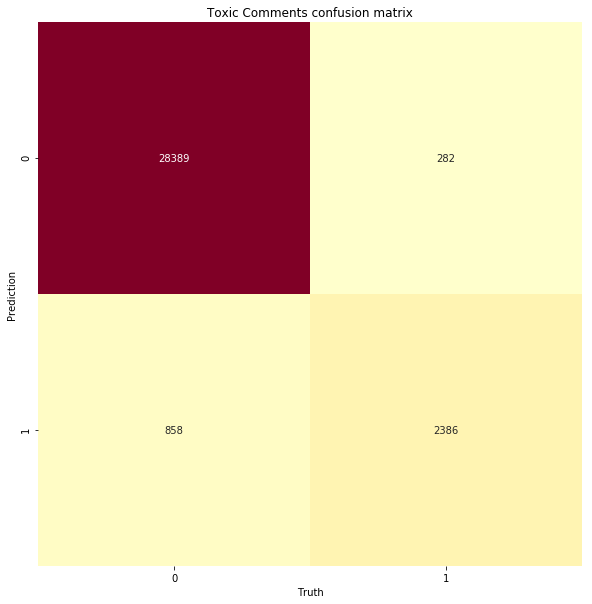

In [24]:
cm = confusion_matrix(y_test, y_pred)
def cm_heatmap(arr, title):
    """Internal. Only called by scoring function."""
    plt.figure('cm_heatmap', figsize=(10,10))
    plt.title(title + ' confusion matrix')
    sns.heatmap(arr, square=True, annot=True, cmap='YlOrRd', fmt='g', cbar=False)
    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    #sns.set(font_scale=3)
    plt.show()
cm_heatmap(cm, "Toxic Comments")